# Section 1.0 Preface & Disclaimer

From the get-go, we realized the importance of seasonality factoring into the analysis of this dataset, but in a more genreral/holistic view, it was due to the data being a time-series spanning two years, with entries (rows) between every hour.

Due to the recent release of NeuralProphet by joint collaboration from Stanford & Facebook (now Meta), solely targeted towards Time-Series Analysis, we have decided to leverage this model format to build our predictive analysis off of.

In [82]:
%pip install git+https://github.com/ourownstory/neural_prophet.git

  Cloning https://github.com/ourownstory/neural_prophet.git to c:\users\sunny\appdata\local\temp\pip-req-build-u7qv_g3o
  Resolved https://github.com/ourownstory/neural_prophet.git to commit 0c8459528d4343c5a8b54d4120b22f089419e423
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for neuralprophet: filename=neuralprophet-0.3.3-py3-none-any.whl size=82316 sha256=f1dffb1c30238ba1fdc48edb52466472e848a33d3f0022119a2a8afe80cad3da
  Stored in directory: C:\Users\sunny\AppData\Local\Temp\pip-ephem-wheel-cache-uzcwkm2i\wheels\32\ce\37\d289cb9c67e62f7912fc3a25e624277ea47902c32e24371a78
Successfully built neuralprophet
  Attempting uninstall: neuralprophet
    Found existing installation: neuralprophet 0

  Running command git clone --filter=blob:none --quiet https://github.com/ourownstory/neural_prophet.git 'C:\Users\sunny\AppData\Local\Temp\pip-req-build-u7qv_g3o'
  Running command git submodule update --init --recursive -q


In [13]:
%pip install neuralprophet
%pip install matplotlib
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [436]:
from neuralprophet import NeuralProphet, set_random_seed, set_log_level; set_random_seed(314159); set_log_level("ERROR", "INFO")
from neuralprophet.df_utils import make_future_df

import pandas as pd
import numpy as np

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True); sns.set_style("whitegrid")

import time

# Section 1.0 Data Display & Description

Using the below predictors/descriptions we output the first `20` entries (rows) as well as basic descriptive statistics of the dataset.

The data is provided to you in NYU Brightspace. It contains 17414 records in total,
ranging from 2015-01-04 to 2017-01-03. In each record, we have the following columns:

* "timestamp" - timestamp field for grouping the data
* "cnt" - the count of new bike shares
* "t1" - real temperature in Celsius
* "t2" - "feels like" temperature in Celsius
* "hum" - humidity in percentage
* "windspeed" - wind speed in km/h
* "weathercode" - category of the weather (1-clear; 2-scattered clouds; 3-broken clouds; 4-
* "cloudy" - 7-light rain; 10-rain with thunderstorm; 26-snowfall; 94-freezing fog)
* "isholiday" – binary variable - 1 holiday / 0 non holiday
* "isweekend" - binary variable - 1 if the day is weekend / 0 non weekend
* "season" – category of the season (0-spring ; 1-summer; 2-fall; 3-winter)

In [393]:
df = pd.read_csv('bike_sharing_dataset.csv')

In [103]:
df.head(30)

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
5,2015-01-04 05:00:00,46,2.0,2.0,93.0,4.0,1.0,0.0,1.0,3.0
6,2015-01-04 06:00:00,51,1.0,-1.0,100.0,7.0,4.0,0.0,1.0,3.0
7,2015-01-04 07:00:00,75,1.0,-1.0,100.0,7.0,4.0,0.0,1.0,3.0
8,2015-01-04 08:00:00,131,1.5,-1.0,96.5,8.0,4.0,0.0,1.0,3.0
9,2015-01-04 09:00:00,301,2.0,-0.5,100.0,9.0,3.0,0.0,1.0,3.0


In [104]:
df.describe(include='all')

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
count,17414,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000
unique,17414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2015-01-04 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1143.101642,12.468091,11.520836,72.324954,15.913063,2.722752,0.022051,0.285403,1.492075
std,NaN,1085.108068,5.571818,6.615145,14.313186,7.894570,2.341163,0.146854,0.451619,1.118911
min,NaN,0.000000,-1.500000,-6.000000,20.500000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,NaN,257.000000,8.000000,6.000000,63.000000,10.000000,1.000000,0.000000,0.000000,0.000000
50%,NaN,844.000000,12.500000,12.500000,74.500000,15.000000,2.000000,0.000000,0.000000,1.000000
75%,NaN,1671.750000,16.000000,16.000000,83.000000,20.500000,3.000000,0.000000,1.000000,2.000000


In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


WARNING - (py.warnings._showwarnmsg) - c:\Users\sunny\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)

WARNING - (py.warnings._showwarnmsg) - c:\Users\sunny\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)

WARNING - (py.warnings._showwarnmsg) - c:\Users\sunny\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)

WARNING - (py.warnings._showwarnmsg) - c:\Users\sunny\AppData\Local\Programs\Python\Python310\lib\site-packages\seabor

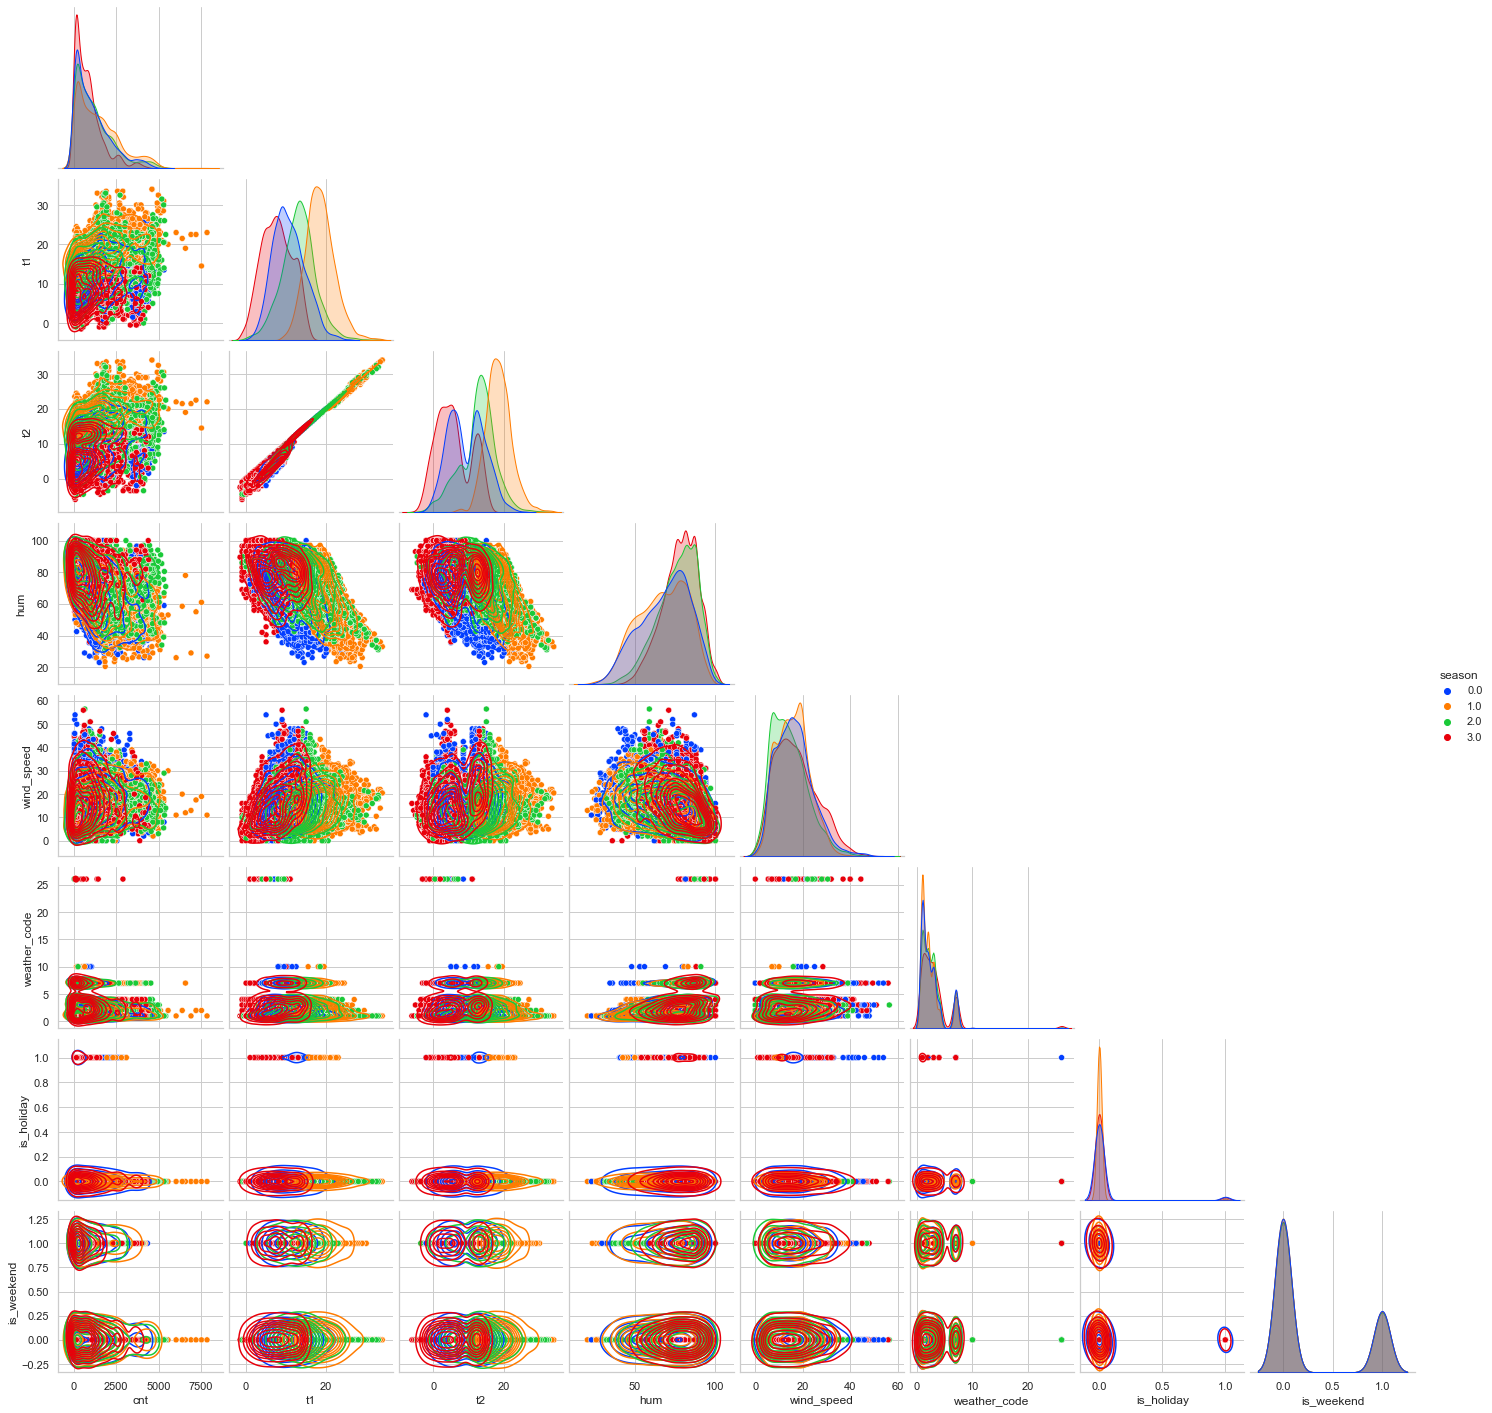

In [6]:
pairplt = sns.pairplot(data=df, hue='season', corner=True, palette='bright')
pairplt.map_lower(sns.kdeplot, levels=10, color=".2")

# Section 2.0 `NeuralProphet` Model Initialization & Fitting

In [454]:
df[['cnt']] = MinMaxScaler().fit_transform(df[['cnt']])

In [455]:
df_train = df.loc[:15112,:]
df_test = df.loc[15112:,:]

In [456]:
train = df_train.rename(columns={'timestamp': 'ds', 'cnt': 'y'})[['ds', 'y']]
test = df_test.rename(columns={'timestamp': 'ds', 'cnt': 'y'})[['ds', 'y']]

In [459]:
def plot_forecast(model, data, periods=0, historic_pred=True, highlight_steps_ahead=None, xlabel='Date', ylabel=None, title=None):
    
    future = model.make_future_dataframe(data, 
                                         periods=periods, 
                                         n_historic_predictions=historic_pred)
    forecast = model.predict(future)
    
    fig, ax = plt.subplots(figsize=(14,10))

    if highlight_steps_ahead is not None:
        model = model.highlight_nth_step_ahead_of_each_forecast(highlight_steps_ahead)
        model.plot_last_forecast(forecast, ax=ax, xlabel=xlabel, ylabel=ylabel)
        ax.set_title(title, fontsize=20, fontweight="bold")

    else:    
        model.plot(forecast, ax=ax, xlabel=xlabel, ylabel=ylabel)
        ax.set_title(title, fontsize=20, fontweight="bold")


In [460]:
def plot_validation(metrics_df, metrics = ['SmoothL1Loss', 'MAE', 'RMSE']):

    fig, axs = plt.subplots(ncols=len(metrics), nrows=1, sharex=True, sharey=True, figsize=(20, 8))
    fig.suptitle('Validation Metrics', fontsize=20, y=0.95)

    for metric, ax in zip(metrics, axs.ravel()):
        ax.plot(metrics_df[metric], 'ob', linewidth=6, label='Training Loss', markersize='3')
        ax.plot(metrics_df[f'{metric}_val'], 'r', linewidth=2, label='Validation Loss')

        ax.set_xlabel('Training Loss')
        ax.set_ylabel('Validation Loss')
        ax.set_title(metric)
        ax.legend()

## Section 2.1 - Model 1

In [479]:
model1 = NeuralProphet() ## Need to figure out n_lags

In [480]:
metrics1 = model1.fit(train, freq='D', validation_df=test)

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

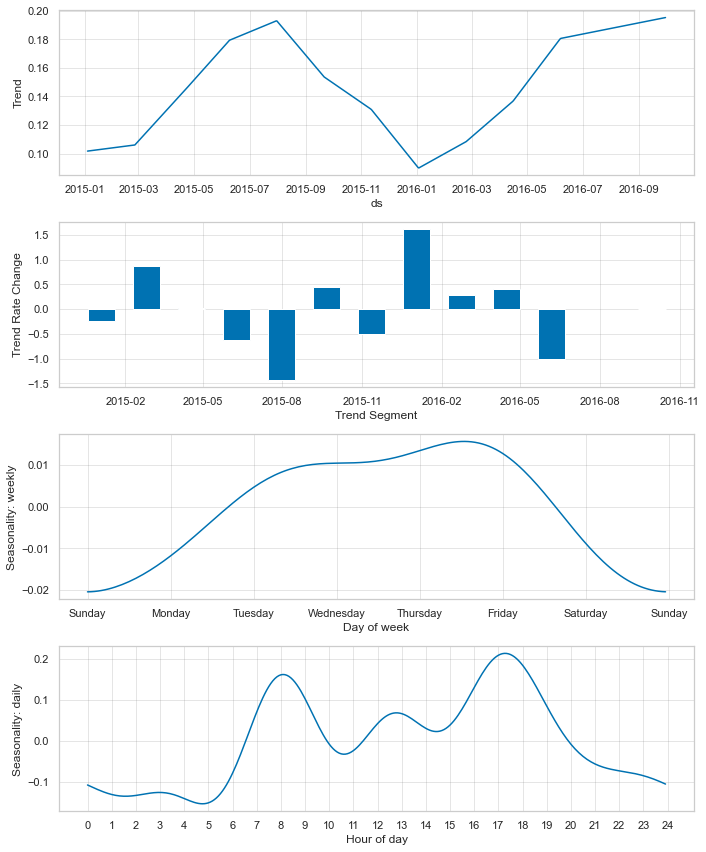

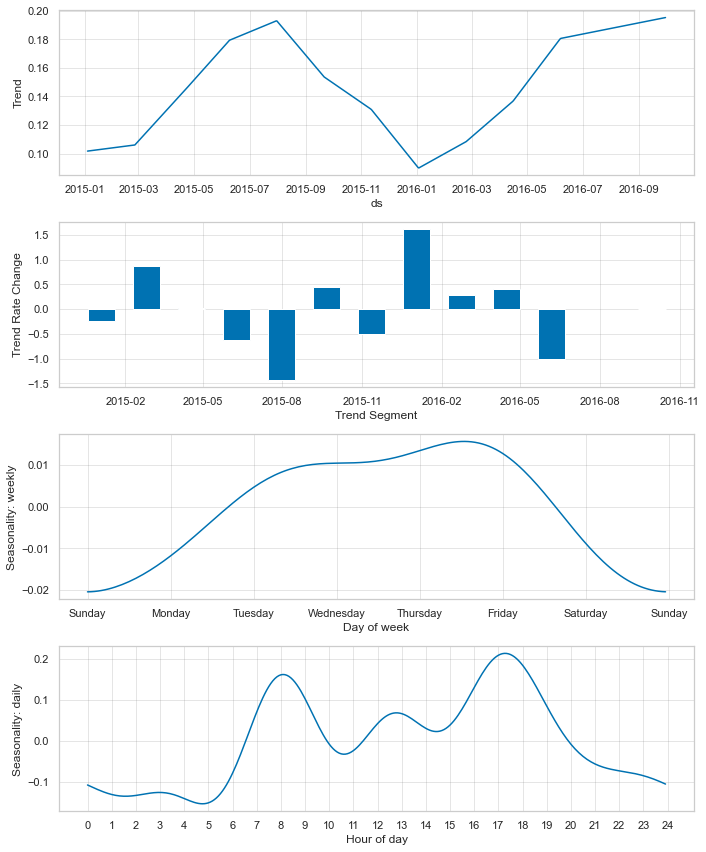

In [481]:
model1.plot_parameters()

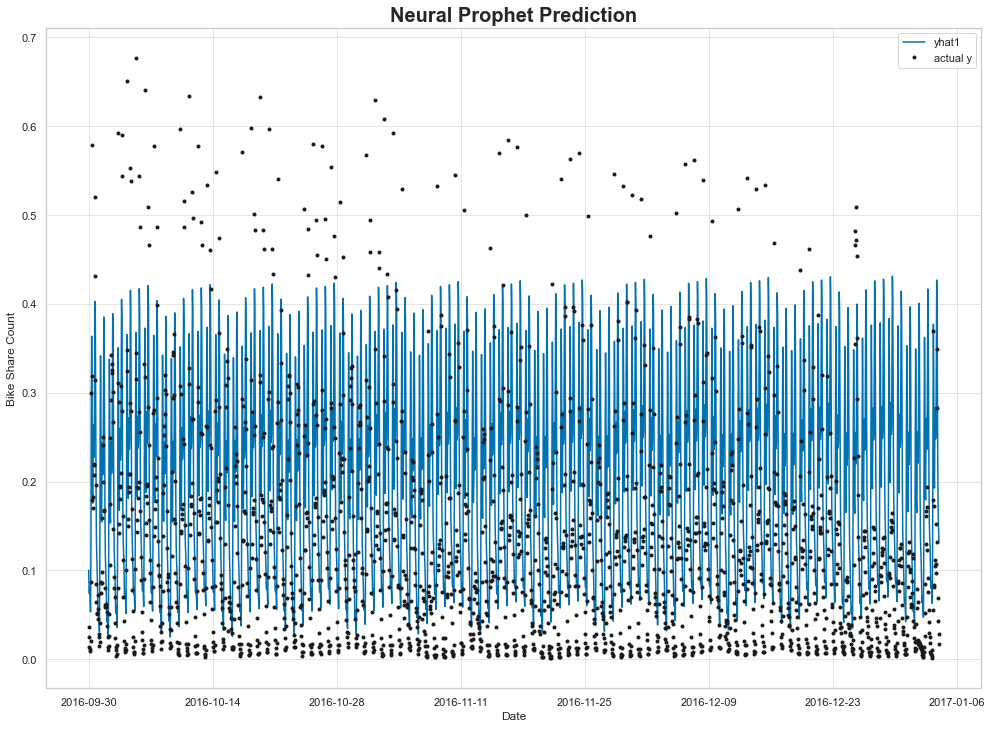

In [482]:
plot_forecast(model1, test, xlabel='Date', ylabel='Bike Share Count', title='Neural Prophet Prediction')

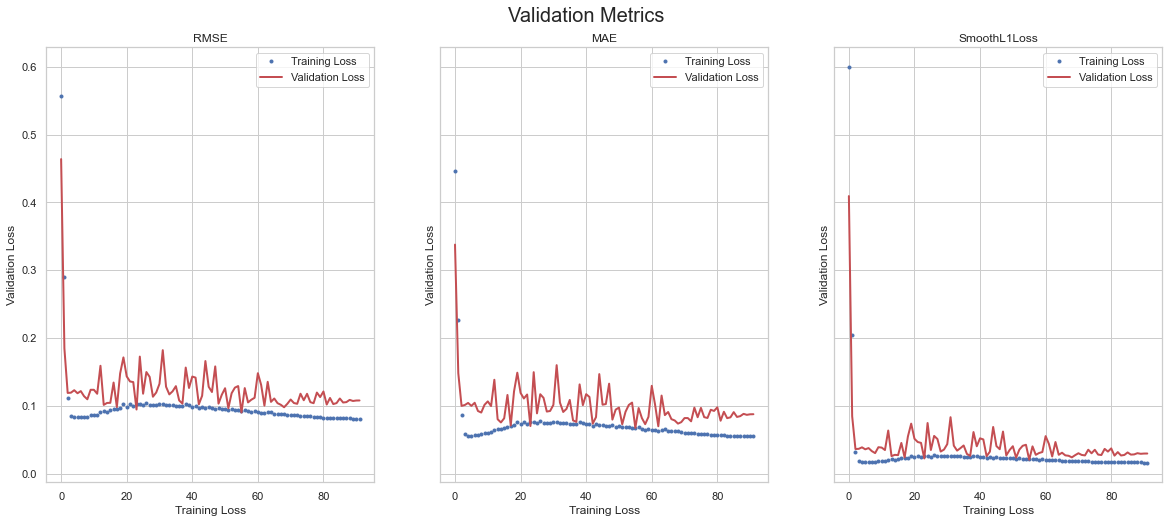

In [483]:
plot_validation(metrics1, metrics=['RMSE', 'MAE', 'SmoothL1Loss'])

In [484]:
metrics1

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
0,0.599606,0.446754,0.557707,0.0,0.409440,0.337844,0.463997
1,0.204378,0.226727,0.289708,0.0,0.084672,0.148277,0.184713
2,0.031974,0.086021,0.111702,0.0,0.036296,0.099905,0.119027
3,0.018148,0.057854,0.085440,0.0,0.036586,0.101244,0.119430
4,0.017374,0.055958,0.083602,0.0,0.038771,0.104285,0.123060
...,...,...,...,...,...,...,...
87,0.016484,0.055484,0.081545,0.0,0.028344,0.084843,0.105492
88,0.016436,0.055497,0.081383,0.0,0.030158,0.088179,0.108798
89,0.016412,0.055260,0.081192,0.0,0.029237,0.086720,0.107150
90,0.016376,0.055273,0.081004,0.0,0.029600,0.087535,0.107831


## Section 2.2 - Model 2

In [526]:
model2 = NeuralProphet(
    growth='linear',  # Determine trend types: 'linear', 'discontinuous', 'off'
    changepoints=None, # list of dates that may include change points (None -> automatic )
    n_changepoints=52, # Number of weeks in a month, looks at a potential changepoint evey month
    changepoints_range=1, # Set to 1 for use of changepoints throughout the time-series
    trend_reg=0, # Changed to 0 for no flexibility in selection of changepoints
    trend_reg_threshold=False, # Requires regularization for trend to be changed
    yearly_seasonality='auto', # Automatically fits yearly seasonality
    weekly_seasonality='auto', # Automatically fits weekly seasonality
    daily_seasonality='auto', # Automatically fits daily seasonality
    seasonality_mode='additive', # Additional (adds) seasonality instead of multiplicative (multiplies) seasonality
    seasonality_reg=0, # Due to the dataset being based on bike shares, visually will be very impacted by seasonality: set at maximum
    n_forecasts=1, # Set at default 1 for forecasting one step ahead
    n_lags=7, # To include 7 days worth of AR lag
    num_hidden_layers=8, # 8 hidden layers for the network
    d_hidden=64, # Dimension of hidden layers of AR-Net
    learning_rate=None, # Automatically determines learning rate
    epochs=None, # Automatically sets the learning rate (based on data size)
    loss_func='Huber', # Sets Huber loss function for robustness to outliers ### Describe Huber in presentation/write-up
    # normalize='auto',  # Type of normalization ('minmax', 'standardize', 'soft', 'auto', None) ## Why normalize again?
)

model2.add_country_holidays('USA') # Adds effects of US holidays
model2.add_seasonality(name='Seasons', period=365, fourier_order=1) # Adds seasonality component with first order fourier series for simple cyclical effects

In [527]:
metrics2 = model2.fit(train, freq='D', validation_df=test)

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

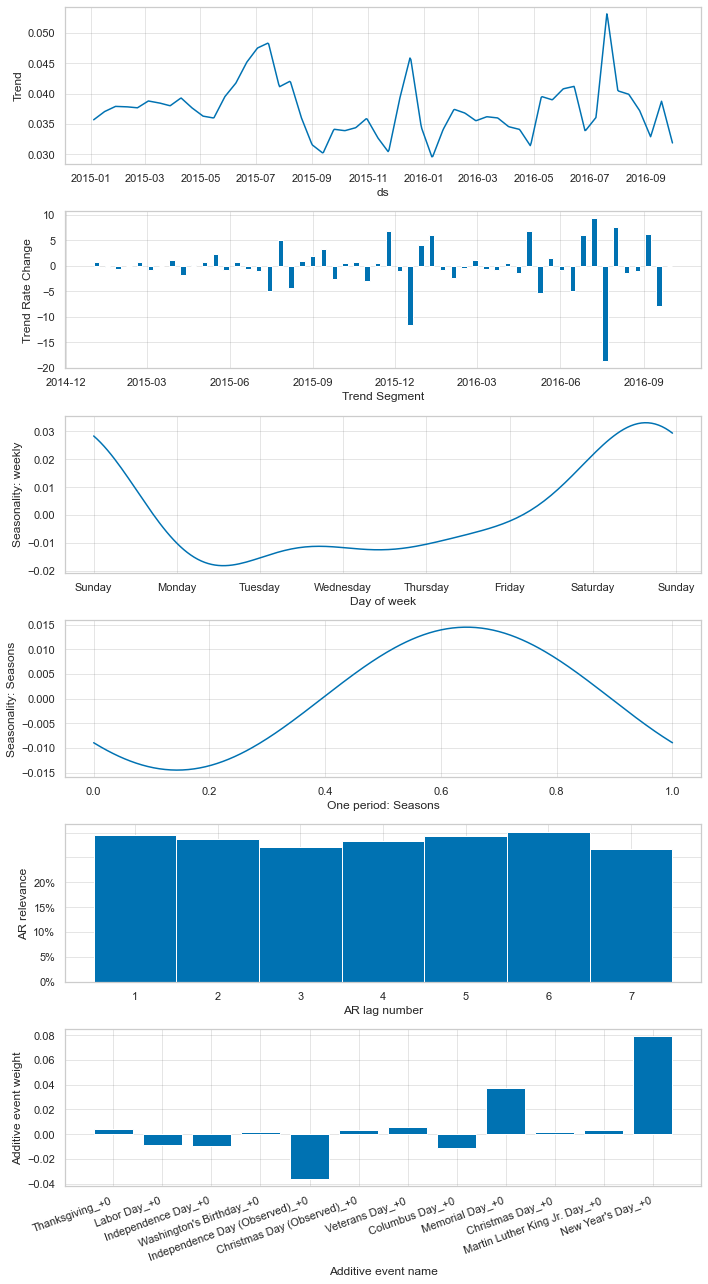

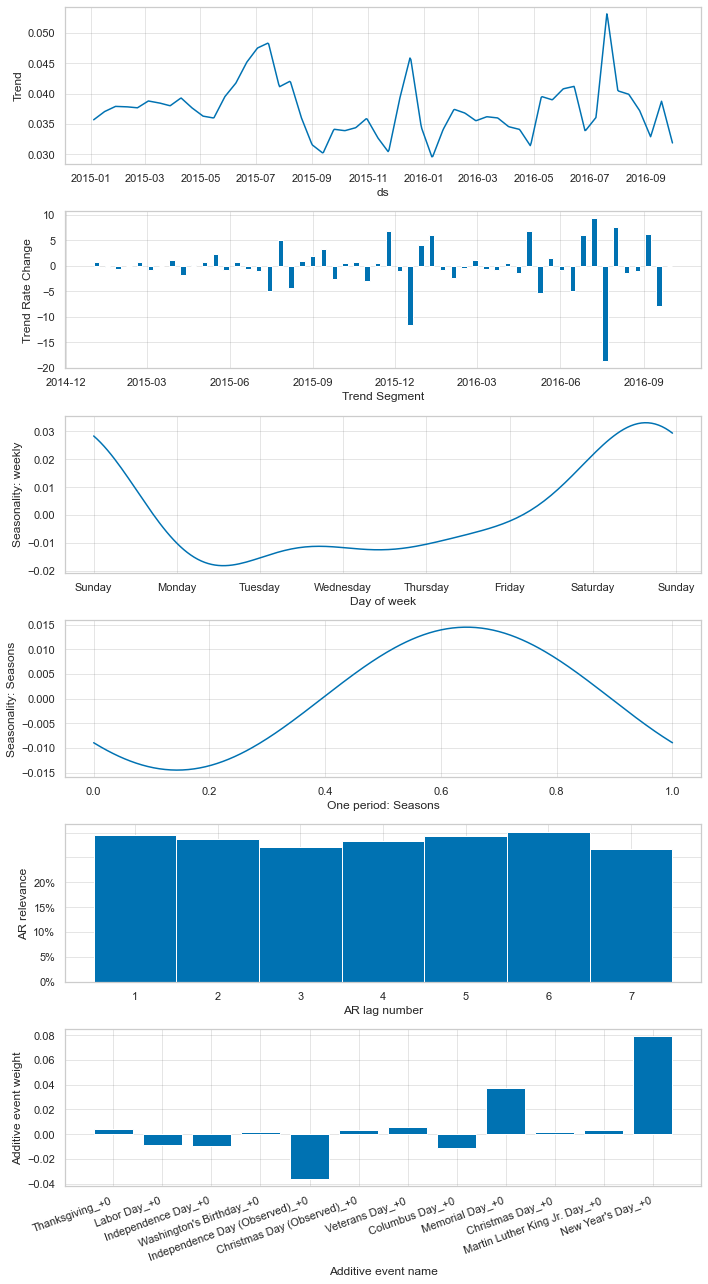

In [528]:
model2.plot_parameters()

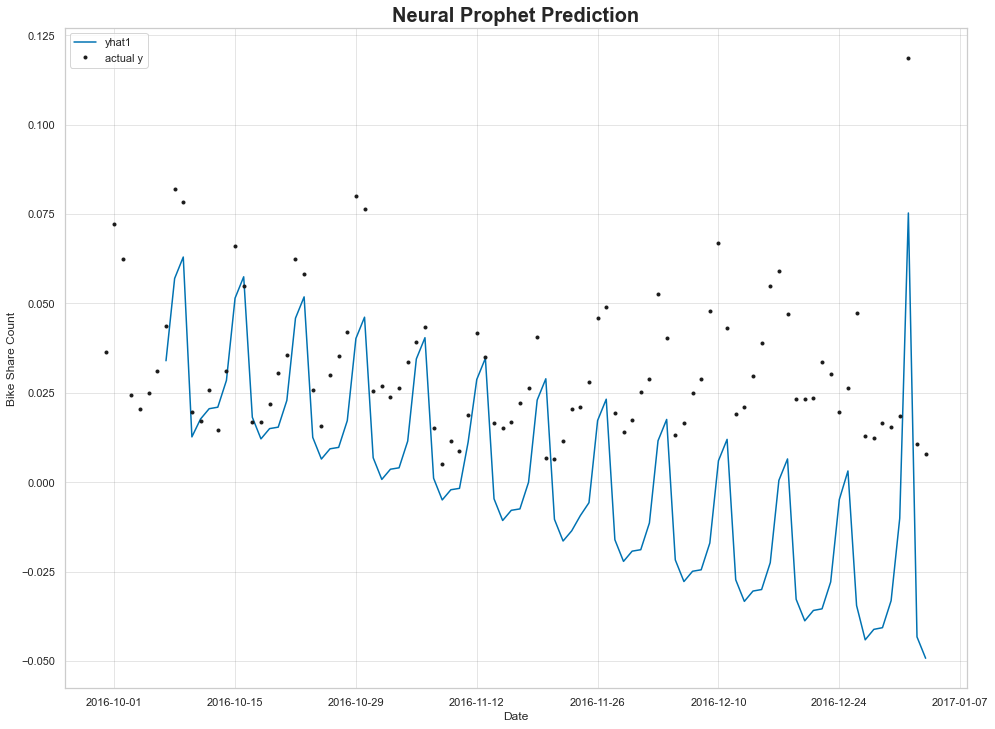

In [529]:
plot_forecast(model2, test, xlabel='Date', ylabel='Bike Share Count', title='Neural Prophet Prediction')

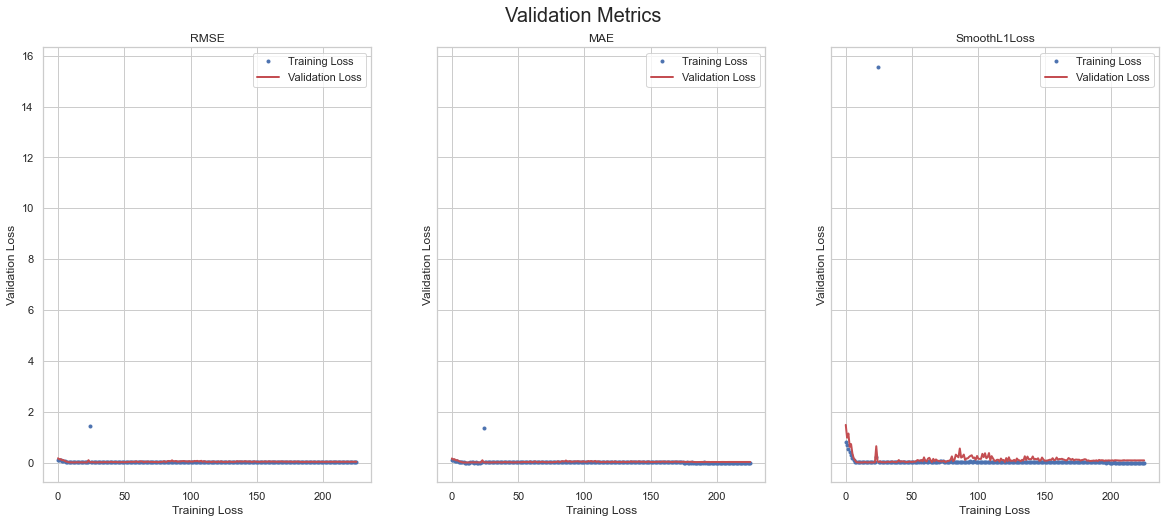

In [530]:
plot_validation(metrics2, metrics=['RMSE', 'MAE', 'SmoothL1Loss'])

In [531]:
metrics2.head(50)

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
0,0.804267,0.104564,0.122999,0.0,1.487446,0.168439,0.175332
1,0.680328,0.093091,0.110388,0.0,0.984391,0.124421,0.133392
2,0.531503,0.079691,0.093480,0.0,1.148458,0.139393,0.145235
3,0.425387,0.069723,0.081382,0.0,0.622351,0.092244,0.099003
4,0.313807,0.058270,0.068797,0.0,0.732738,0.103481,0.107477
5,0.186944,0.044030,0.051642,0.0,0.366367,0.068858,0.073333
6,0.099213,0.030850,0.037329,0.0,0.171470,0.045640,0.049761
7,0.037738,0.018461,0.022650,0.0,0.093699,0.033257,0.036736
8,0.020595,0.013197,0.016790,0.0,0.022365,0.012766,0.017952
9,0.011741,0.009142,0.012384,0.0,0.014822,0.009471,0.014611


## Section 2.3 - Model 3

In [532]:
model3 = NeuralProphet(
    growth='linear',  # Determine trend types: 'linear', 'discontinuous', 'off'
    changepoints=None, # list of dates that may include change points (None -> automatic )
    n_changepoints=52, # Number of weeks in a month, looks at a potential changepoint evey month
    changepoints_range=1, # Set to 1 for use of changepoints throughout the time-series
    trend_reg=0, # Changed to 0 for no flexibility in selection of changepoints
    trend_reg_threshold=False, # Requires regularization for trend to be changed
    yearly_seasonality='auto', # Automatically fits yearly seasonality
    weekly_seasonality='auto', # Automatically fits weekly seasonality
    daily_seasonality='auto', # Automatically fits daily seasonality
    seasonality_mode='additive', # Additional (adds) seasonality instead of multiplicative (multiplies) seasonality
    seasonality_reg=0, # Due to the dataset being based on bike shares, visually will be very impacted by seasonality: set at maximum
    n_forecasts=1, # Set at default 1 for forecasting one step ahead
    n_lags=7, ###!!! Hyperparameter tuning from model2 makes n_lags=5 work best
    num_hidden_layers=8, # 8 hidden layers for the network
    d_hidden=64, # Dimension of hidden layers of AR-Net
    learning_rate=None, # Automatically determines learning rate
    epochs=20, ###!!! Manual early stopping based on model2
    loss_func='Huber', # Sets Huber loss function for robustness to outliers ### Describe Huber in presentation/write-up
    # normalize='auto',  # Type of normalization ('minmax', 'standardize', 'soft', 'auto', None)
)

model3.add_country_holidays('USA') # Adds effects of US holidays
model3.add_seasonality(name='Seasons', period=365, fourier_order=1) # Adds seasonality component with first order fourier series for simple cyclical effects

In [533]:
metrics3 = model3.fit(train, freq='D', validation_df=test)

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

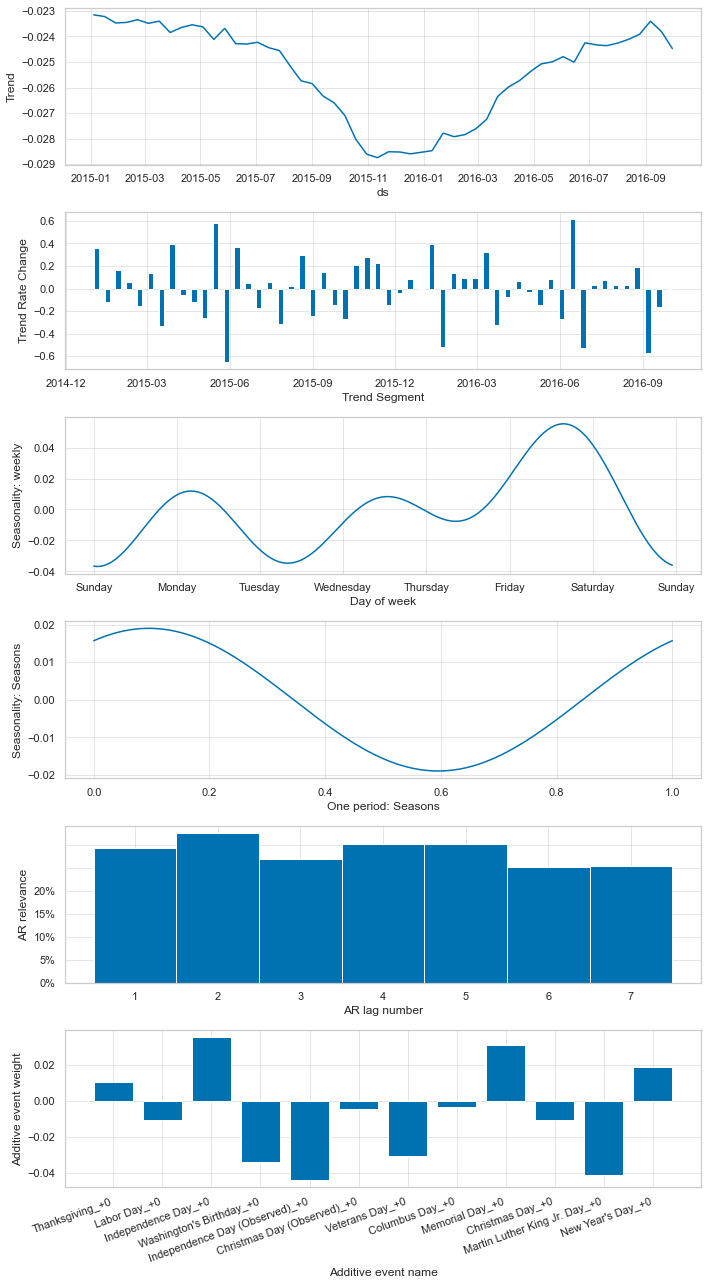

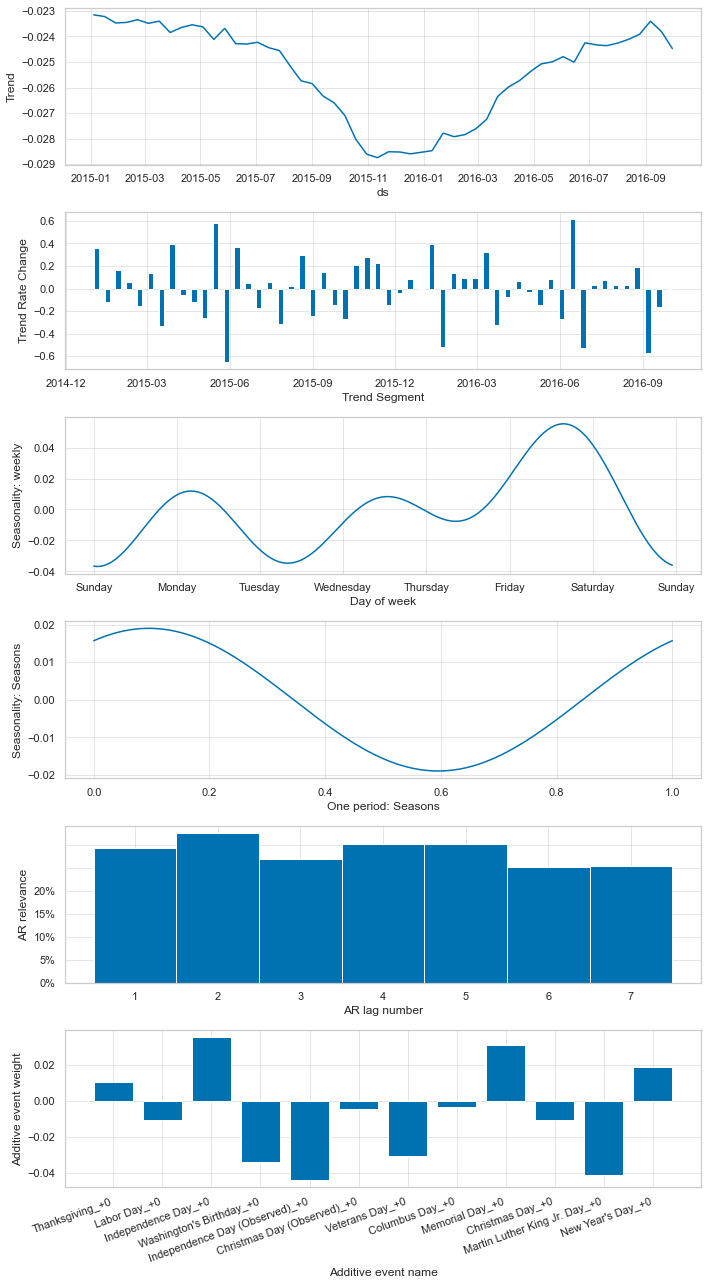

In [534]:
model3.plot_parameters()

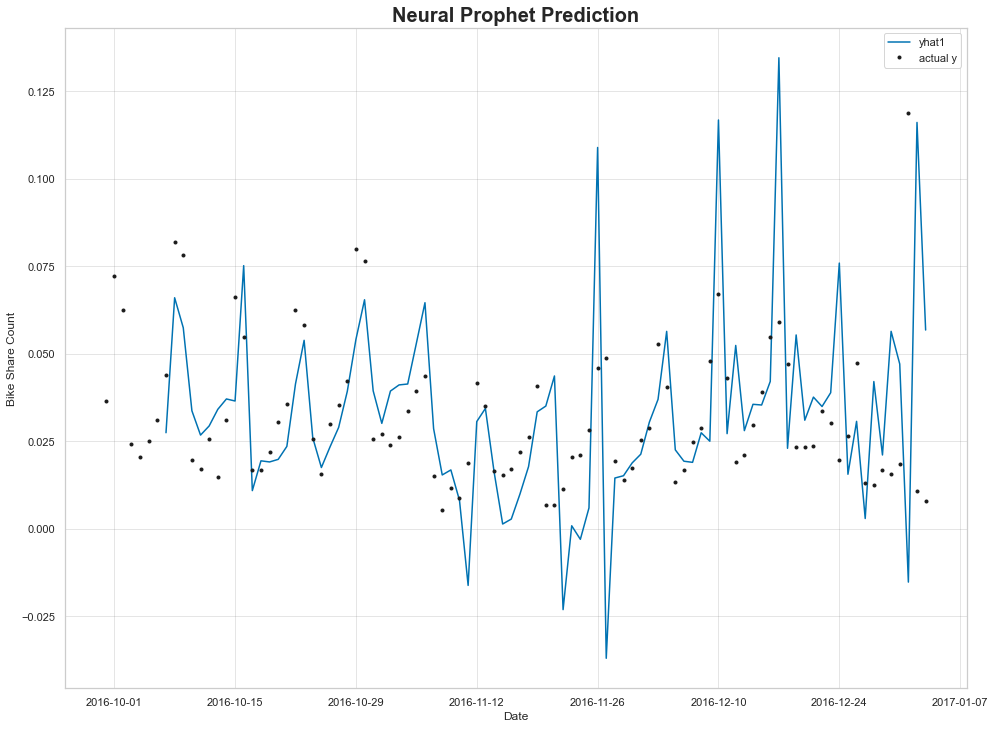

In [535]:
plot_forecast(model3, test, xlabel='Date', ylabel='Bike Share Count', title='Neural Prophet Prediction')

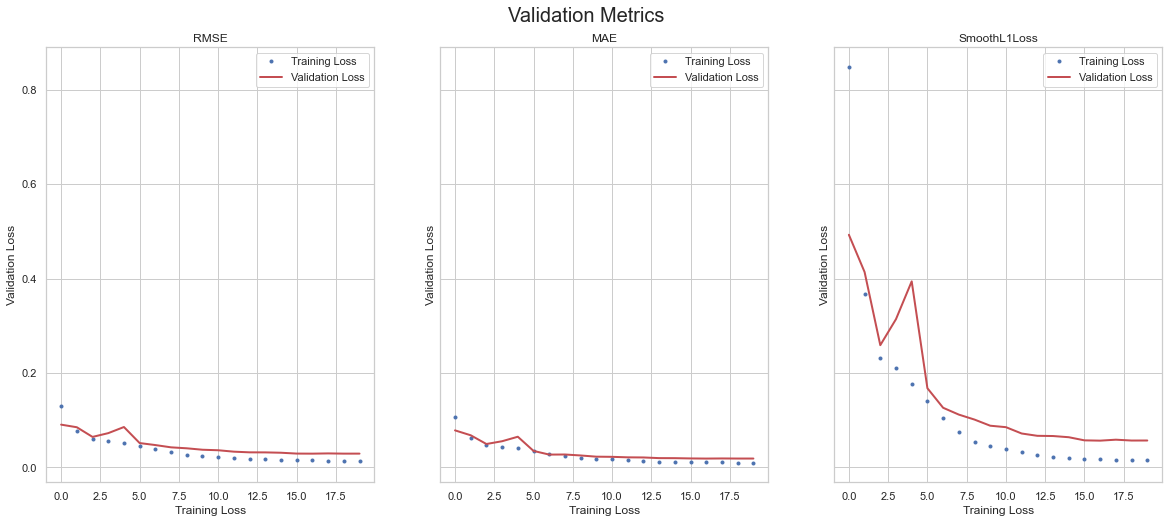

In [536]:
plot_validation(metrics3, metrics=['RMSE', 'MAE', 'SmoothL1Loss'])

In [537]:
metrics3

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
0,0.847610,0.107544,0.130761,0.0,0.492672,0.078461,0.090584
1,0.366275,0.061972,0.076319,0.0,0.413756,0.068059,0.085062
2,0.232661,0.047207,0.059603,0.0,0.258883,0.049555,0.064591
3,0.210811,0.044238,0.056073,0.0,0.314035,0.055461,0.072563
4,0.176869,0.040047,0.051378,0.0,0.394032,0.064967,0.085533
5,0.141008,0.034392,0.044496,0.0,0.167701,0.034926,0.051562
6,0.103931,0.029140,0.038371,0.0,0.126299,0.027141,0.047341
7,0.074558,0.023842,0.031934,0.0,0.111836,0.027339,0.042503
8,0.054673,0.020199,0.027009,0.0,0.101286,0.025296,0.040471
9,0.044885,0.018141,0.024533,0.0,0.088309,0.022729,0.037434


## Section 3.0 - Appendix

WARNING - (py.warnings._showwarnmsg) - c:\Users\sunny\AppData\Local\Programs\Python\Python310\lib\site-packages\neuralprophet\forecaster.py:2060: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

WARNING - (py.warnings._showwarnmsg) - c:\Users\sunny\AppData\Local\Programs\Python\Python310\lib\site-packages\neuralprophet\forecaster.py:1406: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_end_to_append)



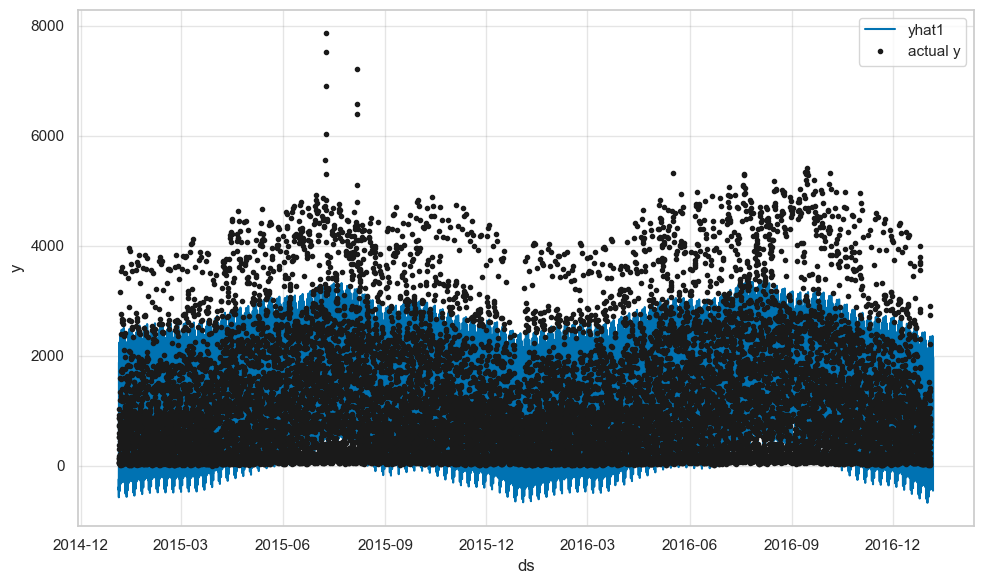

In [10]:
plot_forecast(model, df_test, periods=60)

In [ ]:
preds = list(df)[1:]

In [ ]:
def get_global_df(data, preds):
    df_global = pd.DataFrame()
    for pred in preds:
        aux = df[['ds', pred]].copy(deep = True) #select column associated with region
        df.reset_index(drop=True, inplace=True)
        # aux = aux.iloc[:26301, :].copy(deep = True) #selects data up to 26301 row (2004 to 2007 time stamps)
        aux = aux.rename(columns = {pred: 'y'}) #rename column of data to 'y' which is compatible with Neural Prophet
        aux['ID'] = pred
        df_global = pd.concat((df_global, aux))
    
    return df_global

In [ ]:
df_test = df.rename(columns={'timestamp': 'ds', 'cnt': 'y'})[['ds', 'y']]

In [ ]:
future = model.make_future_dataframe(df_test, n_historic_predictions = True)
forecast = model.predict(future)
fig = model.plot(forecast[forecast['ID'] ==  'NORTH'])

In [ ]:
def plot_forecast(model, data, pred_names, historic_pred=True):
    
    future = model.make_future_dataframe(data, 
                                         n_historic_predictions=historic_pred)
    forecast = model.predict(future)
    
    def plot_subplots(model, forecast, pred_names):

        pred_len = len(pred_names)
        num_cols = int(np.sqrt(pred_len))
        num_rows = int(pred_len / num_cols)

        fig, axs = plt.subplots(nrows = num_rows + (1 if pred_len % num_cols != 0 else 0), ncols = num_cols, figsize = (10 * num_rows, 10 * num_cols))
        fig.suptitle('Subplots for Global Model Using Local Normalization', fontsize=20, y=0.95)

        for pred, ax in zip(pred_names, axs.ravel()):
            model.plot(forecast[forecast['ID'] == pred], xlabel='Date', ylabel='Bike Share Count', ax=ax)
            ax.set_title(pred)

    plot_subplots(model, forecast, pred_names)

In [ ]:
df_train = df.loc[(df['timestamp'] >= '2015-01-04') & (df['timestamp'] <= '2016-09-30')]
df_test = df.loc[(df['timestamp'] >= '2016-10-01') & (df['timestamp'] <= '2017-01-03')]

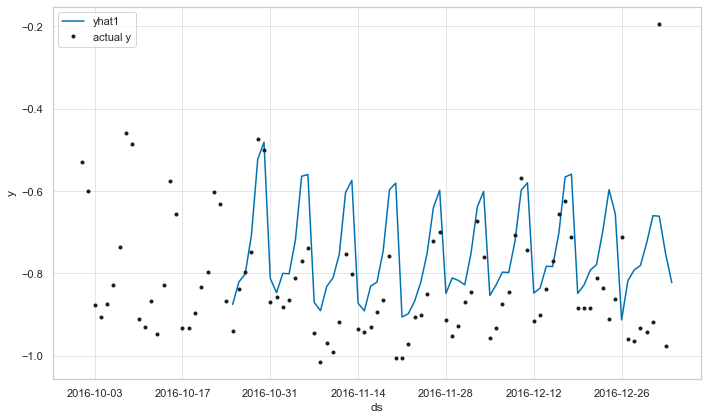

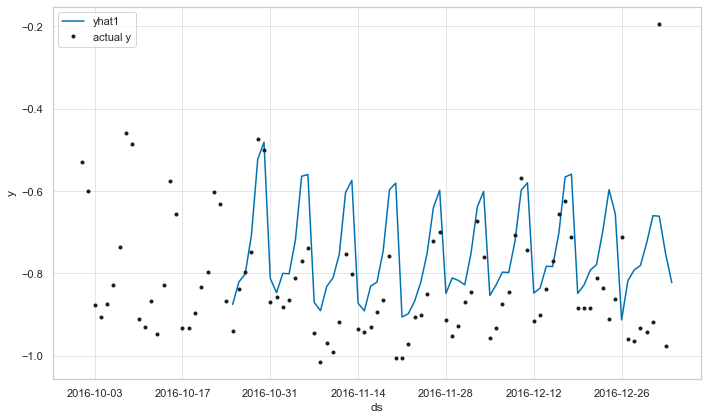

In [ ]:
future = model.make_future_dataframe(test, n_historic_predictions=True)
forecast = model.predict(future)
model.plot(forecast, df_name='cnt')